C:\Users\anany\AppData\Local\Programs\Python\Python312\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


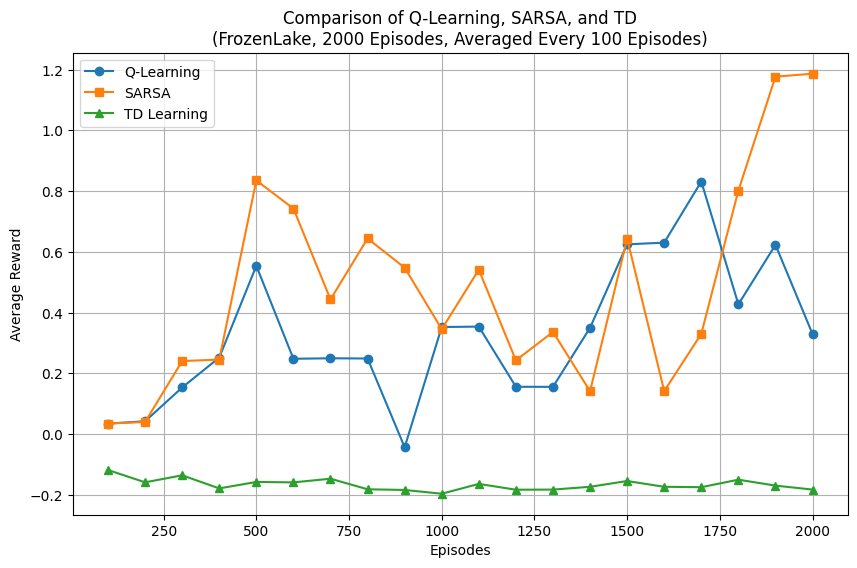

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt

# Environment
env = gym.make('FrozenLake-v1', is_slippery=True)
state_space = env.observation_space.n
action_space = env.action_space.n

# Hyperparameters
episodes = 2000
learning_rate = 0.1
discount_factor = 0.99
epsilon = 1.0
epsilon_decay_rate = 0.001
min_epsilon = 0.01

# Track rewards
rewards_q_learning = []
rewards_sarsa = []
rewards_td = []

# --- Q-Learning ---
Q_table = np.random.rand(state_space, action_space) * 0.01

def epsilon_greedy_action_q(state, epsilon):
    if np.random.rand() < epsilon:
        return env.action_space.sample()
    else:
        return np.argmax(Q_table[state])

for episode in range(episodes):
    state, _ = env.reset()
    done = False
    total_reward = 0
    while not done:
        action = epsilon_greedy_action_q(state, epsilon)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        reward = 10 if reward == 1 else -0.01

        best_next_action = np.argmax(Q_table[next_state])
        target = reward + discount_factor * Q_table[next_state, best_next_action]
        Q_table[state, action] += learning_rate * (target - Q_table[state, action])

        state = next_state
        total_reward += reward
    epsilon = max(min_epsilon, epsilon * np.exp(-epsilon_decay_rate * episode))
    rewards_q_learning.append(total_reward)

# --- SARSA ---
epsilon = 1.0
Q_table = np.random.rand(state_space, action_space) * 0.01

def epsilon_greedy_action_sarsa(state, epsilon):
    if np.random.rand() < epsilon:
        return env.action_space.sample()
    else:
        return np.argmax(Q_table[state])

for episode in range(episodes):
    state, _ = env.reset()
    action = epsilon_greedy_action_sarsa(state, epsilon)
    done = False
    total_reward = 0
    while not done:
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        reward = 10 if reward == 1 else -0.01

        next_action = epsilon_greedy_action_sarsa(next_state, epsilon)
        target = reward + discount_factor * Q_table[next_state, next_action]
        Q_table[state, action] += learning_rate * (target - Q_table[state, action])

        state = next_state
        action = next_action
        total_reward += reward
    epsilon = max(min_epsilon, epsilon * np.exp(-epsilon_decay_rate * episode))
    rewards_sarsa.append(total_reward)

# --- TD (Value Iteration Approx) ---
epsilon = 1.0
V_table = np.random.rand(state_space) * 0.01

def epsilon_greedy_action_td(state, epsilon):
    if np.random.rand() < epsilon:
        return env.action_space.sample()
    else:
        return np.argmax([V_table[state] for _ in range(action_space)])

for episode in range(episodes):
    state, _ = env.reset()
    done = False
    total_reward = 0
    while not done:
        action = epsilon_greedy_action_td(state, epsilon)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        reward = 10 if reward == 1 else -0.01

        target = reward + discount_factor * V_table[next_state]
        V_table[state] += learning_rate * (target - V_table[state])

        state = next_state
        total_reward += reward
    epsilon = max(min_epsilon, epsilon * np.exp(-epsilon_decay_rate * episode))
    rewards_td.append(total_reward)

# --- Plotting ---
# Smooth rewards: average over every 100 episodes
def smooth_rewards(rewards, chunk_size=100):
    return np.mean(np.array(rewards).reshape(-1, chunk_size), axis=1)

chunk_size = 100
x_values = np.arange(chunk_size, episodes + 1, chunk_size)

plt.figure(figsize=(10, 6))
plt.plot(x_values, smooth_rewards(rewards_q_learning, chunk_size), marker='o', label='Q-Learning')
plt.plot(x_values, smooth_rewards(rewards_sarsa, chunk_size), marker='s', label='SARSA')
plt.plot(x_values, smooth_rewards(rewards_td, chunk_size), marker='^', label='TD Learning')

plt.title('Comparison of Q-Learning, SARSA, and TD\n(FrozenLake, 2000 Episodes, Averaged Every 100 Episodes)')
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.legend()
plt.grid(True)
plt.show()
